In [2]:
import tensorflow as tf
from keras import __version__
tf.keras.__version__ = __version__
from imp import reload

import time
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Embedding, Reshape

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

from env_class import BatteryManagementEnv

plt.style.use("ggplot")

In [3]:
env = BatteryManagementEnv(24)
env.reset()

array([1.000000e+01, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 7.925000e+01, 6.552500e+02, 1.460750e+03,
       2.027250e+03, 2.212500e+03, 1.915750e+03, 1.184250e+03,
       3.672500e+02, 1.925000e+01, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 1.887975e+04, 2.062650e+04, 2.235550e+04,
       2.403250e+04, 2.545200e+04, 2.652650e+04, 2.805850e+04,
       2.884500e+04, 2.926700e+04, 2.985400e+04, 3.046150e+04,
       3.107075e+04, 3.163425e+04, 3.234400e+04, 3.301850e+04,
       3.369250e+04, 3.437825e+04, 3.506600e+04, 3.577750e+04,
       3.626775e+04, 3.642975e+04, 3.656475e+04, 3.590650e+04,
       3.552725e+04, 5.069000e+03, 5.042250e+03, 5.028500e+03,
       4.977750e+03, 4.907250e+03, 4.882750e+03, 4.876250e+03,
       4.893250e+03, 4.907750e+03, 4.922500e+03, 4.923500e+03,
       4.887000e+03, 4.581250e+03, 4.416750e+03, 4.3867

In [4]:
# from keras.layers import Dense, Input
# from keras.models import Model

# #build neural network for DQN
# def build_model(states, actions):
#     input = Input(shape=(1,states))
#     x = Flatten()(input)
#     x = Dense(16, activation='relu')(x)
#     #output layer
#     output = Dense(actions, activation='linear')(x)

#     model = Model(inputs=input, outputs=output)

#     return model

# model = build_model(env.observation_space, env.nA)

from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

def build_enhanced_model(states, actions):
    # Define the input layer
    input_layer = Input(shape=(1,states))  # Adjusted for a flat input vector

    # Flatten the input if it's multidimensional
    if len(input_layer.shape) > 2:
        x = Flatten()(input_layer)
    else:
        x = input_layer

    # First hidden layer
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = Dropout(0.2)(x)  # Dropout layer

    x= Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Second hidden layer
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Output layer
    output = Dense(actions, activation='linear')(x)

    # Create the Keras Model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(lr=0.001), loss='mse')

    return model

model = build_enhanced_model(env.observation_space, env.nA)


Instructions for updating:
Colocations handled automatically by placer.


In [5]:
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from keras.src.saving import serialization_lib
serialization_lib.enable_unsafe_deserialization()
from tensorflow.keras.optimizers.legacy import Adam

# Then, define DQN agent in Keras-RL
memory = SequentialMemory(limit=20000, window_length=1)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(eps=0), 
                              attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=10000)
dqn = DQNAgent(model=model, nb_actions=env.nA, memory=memory, policy=policy,
                nb_steps_warmup=500, target_model_update=1e-2, enable_double_dqn=True, enable_dueling_network=True)
dqn.compile(optimizer=Adam(learning_rate=1e-3), metrics=['mae'])



In [6]:
from rl.callbacks import FileLogger

log_filename = 'dqn_BatteryManagementEnv_log.json'
logger = FileLogger(log_filename, interval=100)

dqn.fit(env, nb_steps=30000, visualize=False, verbose=1, nb_max_episode_steps=365, log_interval=1000,callbacks=[logger])

Training for 30000 steps ...
Interval 1 (0 steps performed)


c:\Users\volco\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


1000/1000 [==============================] - 7s 7ms/step - reward: -8.5934
2 episodes - episode_reward: -3212.999 [-3268.054, -3157.944] - loss: 3595826.058 - mae: 21.241 - mean_q: 2.048 - mean_eps: 0.932

Interval 2 (1000 steps performed)
1000/1000 [==============================] - 8s 8ms/step - reward: -8.8368
3 episodes - episode_reward: -3221.799 [-3305.647, -3146.876] - loss: 43.351 - mae: 2.278 - mean_q: 2.036 - mean_eps: 0.865

Interval 3 (2000 steps performed)
1000/1000 [==============================] - 8s 8ms/step - reward: -8.3586
3 episodes - episode_reward: -3159.573 [-3274.058, -3087.143] - loss: 46.459 - mae: 2.702 - mean_q: 1.932 - mean_eps: 0.775

Interval 4 (3000 steps performed)
1000/1000 [==============================] - 8s 8ms/step - reward: -7.7786
2 episodes - episode_reward: -2763.011 [-2822.300, -2703.722] - loss: 50.183 - mae: 3.902 - mean_q: 1.714 - mean_eps: 0.685

Interval 5 (4000 steps performed)
1000/1000 [==============================] - 8s 8ms/step -

In [ ]:
# from rl.callbacks import FileLogger

# log_filename = 'dqn_BatteryManagementEnv_log.json'
# logger = FileLogger(log_filename, interval=100)

# dqn.fit(env, nb_steps=5000, visualize=False, verbose=1, callbacks=[logger])


In [7]:
import json

with open(log_filename, 'r') as file:
    data = json.load(file)
    print(data.keys())  # This will show you the keys at the top level of your log file.
    if 'episode_reward' in data:
        print(data['episode_reward'])  # This is to check if reward data exists and see its format.
    else:
        print("Reward data not found.")


dict_keys(['loss', 'mae', 'mean_q', 'mean_eps', 'episode_reward', 'nb_episode_steps', 'nb_steps', 'episode', 'duration'])
[-3157.943784231038, -3268.0543160386337, -3146.8760320958495, -3305.6469309232225, -3212.872844083431, -3274.058221472586, -3087.1431997080167, -3117.517031558748, -2822.3001673078375, -2703.722035334506, -2593.761112383372, -2807.28865076236, -2341.4743882871007, -2413.85627966535, -2061.9302599062794, -1874.7384339966375, -1843.9213810987367, -1803.7262628912883, -1408.3729200319076, -1369.1744615548414, -1049.7050301869622, -840.8203874962, -905.4129040313686, -555.6577420097213, -470.35961347049243, -404.5356288975691, -342.8619184511798, -227.1142901248299, -266.94741290671817, -169.8079268759053, -149.26107596861206, -115.62106748703606, -408.8790487712316, -203.12756188393558, -290.2624033052072, -315.4949722094434, -5.906780766269304, -150.3451522111029, -151.21740133701476, -79.21882713559037, -289.1828527220066, -10.096242191751017, -137.99563756381647, -

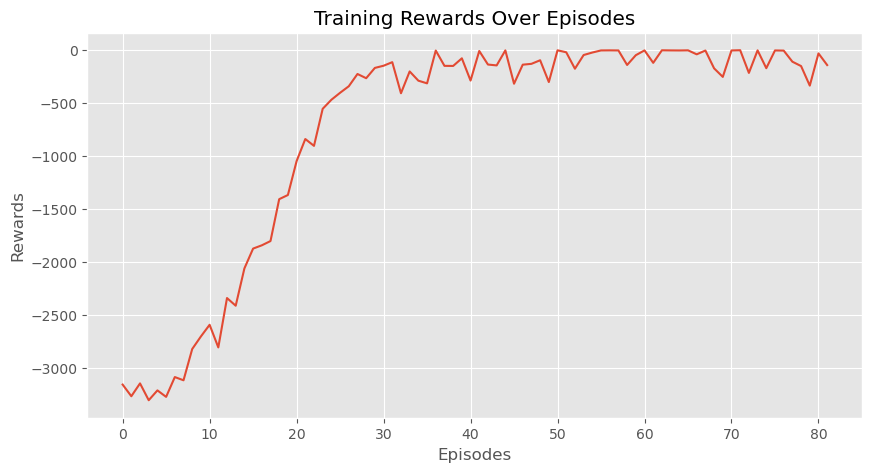

In [8]:
def plot_rewards(log_filename):
    with open(log_filename, 'r') as file:
        data = json.load(file)
        
    # Check if 'episode_rewards' is the correct key and adapt if necessary
    if 'episode_reward' in data:
        rewards = data['episode_reward']  # Directly use rewards if they are not nested
        plt.figure(figsize=(10, 5))
        plt.plot(rewards)
        plt.title('Training Rewards Over Episodes')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.grid(True)
        plt.show()

       
    else:
        print("No reward data available for plotting. Check the key names in the log file.")

plot_rewards('dqn_BatteryManagementEnv_log.json')


In [ ]:
env_test = BatteryManagementEnv(1000)
env_test.reset()

#test the model
dqn.test(env_test, nb_episodes=15, visualize=False, nb_max_episode_steps=1000)

Testing for 15 episodes ...
Episode 1: reward: 2160.519, steps: 365
Episode 2: reward: 2160.519, steps: 365
Episode 3: reward: 2160.519, steps: 365
Episode 4: reward: 2160.519, steps: 365
Episode 5: reward: 2160.519, steps: 365
Episode 6: reward: 2160.519, steps: 365
Episode 7: reward: 2160.519, steps: 365
Episode 8: reward: 2160.519, steps: 365
Episode 9: reward: 2160.519, steps: 365
Episode 10: reward: 2160.519, steps: 365
Episode 11: reward: 2160.519, steps: 365
Episode 12: reward: 2160.519, steps: 365
Episode 13: reward: 2160.519, steps: 365
Episode 14: reward: 2160.519, steps: 365
Episode 15: reward: 2160.519, steps: 365


In [ ]:
from rl.callbacks import TestLogger

# Setup testing environment
env_test = BatteryManagementEnv(0*366+24)
env_test.reset()

# Testing the model
history = dqn.test(env_test, nb_episodes=1, visualize=False,nb_max_episode_steps=365)

Testing for 1 episodes ...
Episode 1: reward: 198.314, steps: 365


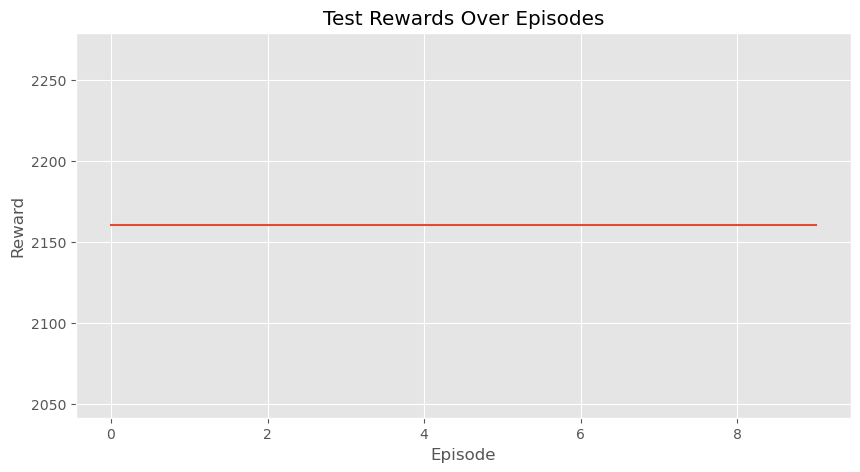

In [ ]:
test_rewards = history.history['episode_reward']

def plot_test_rewards(test_rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(test_rewards)
    plt.title('Test Rewards Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()

plot_test_rewards(test_rewards)


In [ ]:
def train_agent(env, agent, nb_steps, seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    env.seed(seed)
    
    log_filename = f'dqn_BatteryManagementEnv_seed_{seed}_log.json'
    logger = FileLogger(log_filename, interval=100)

    agent.fit(env, nb_steps=5000, visualize=False, verbose=1, nb_max_episode_steps=365, log_interval=1000, callbacks=[logger])

    return log_filename


In [ ]:
seeds = [42, 43, 44, 45]  # Example seeds
log_filenames = [train_agent(env, dqn, 50000, seed) for seed in seeds]


Training for 5000 steps ...
Interval 1 (0 steps performed)
1000/1000 [==============================] - 21s 21ms/step - reward: -2.1022
2 episodes - episode_reward: -781.905 [-788.053, -775.757] - loss: 3.284 - mae: 34.785 - mean_q: 46.699 - mean_eps: 0.932

Interval 2 (1000 steps performed)
1000/1000 [==============================] - 45s 45ms/step - reward: -1.8824
3 episodes - episode_reward: -694.679 [-741.217, -630.033] - loss: 3.287 - mae: 34.551 - mean_q: 46.374 - mean_eps: 0.865

Interval 3 (2000 steps performed)
1000/1000 [==============================] - 37s 37ms/step - reward: -1.4292
3 episodes - episode_reward: -545.100 [-680.293, -475.639] - loss: 3.483 - mae: 35.115 - mean_q: 47.026 - mean_eps: 0.775

Interval 4 (3000 steps performed)
1000/1000 [==============================] - 43s 43ms/step - reward: -1.2112
2 episodes - episode_reward: -482.584 [-515.143, -450.026] - loss: 3.442 - mae: 35.092 - mean_q: 46.898 - mean_eps: 0.685

Interval 5 (4000 steps performed)
1000/

In [ ]:
def aggregate_rewards(log_filenames):
    all_rewards = []

    # Load all reward data
    for filename in log_filenames:
        with open(filename, 'r') as file:
            data = json.load(file)
            all_rewards.append(data['episode_reward'])  # Assuming each file contains 'episode_reward'
    
    # Calculate mean and standard deviation
    
    reward_array = np.array(all_rewards)  # Shape: (num_seeds, num_episodes)
    mean_rewards = np.mean(reward_array, axis=0)
    std_rewards = np.std(reward_array, axis=0)

    return mean_rewards, std_rewards

mean_rewards, std_rewards = aggregate_rewards(log_filenames)


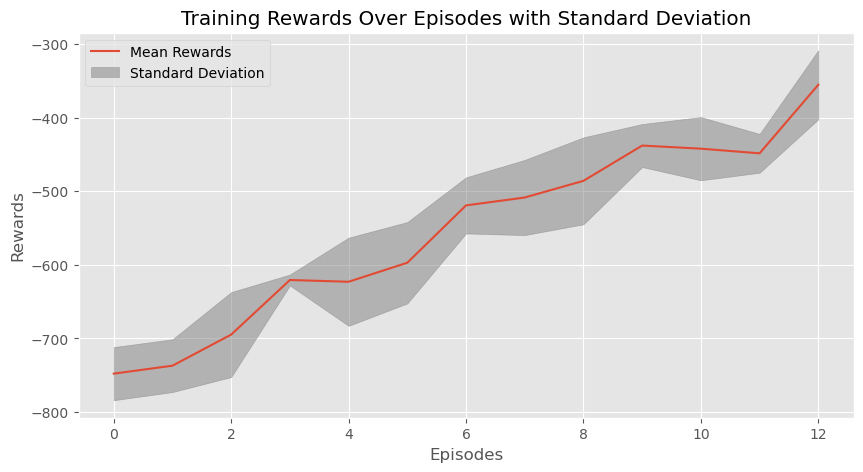

In [ ]:
def plot_rewards_with_std(mean_rewards, std_rewards):
    episodes = np.arange(len(mean_rewards))
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, mean_rewards, label='Mean Rewards')
    plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, color='gray', alpha=0.5, label='Standard Deviation')
    plt.title('Training Rewards Over Episodes with Standard Deviation')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rewards_with_std(mean_rewards, std_rewards)
